# Post-Training Model Debugging 

In [34]:
%load_ext autoreload
%autoreload 2
import torch

import matplotlib.pyplot as plt
import pickle
import math

from enc_dec.utils import viz_tensors_bars, viz_tensors_density, plot_UpdateRatio
from enc_dec.model import TranslGRU

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
log_file = './data/train-log.txt'
trained_model = './data/saved_model.pkl'

# Loss Curves

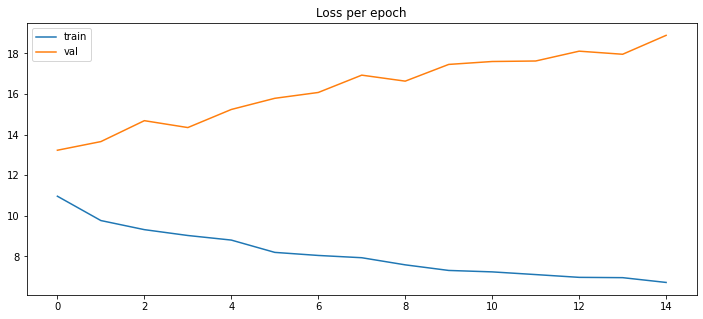

In [36]:
losses = []
val_losses = []
with open(log_file, "r") as f:
  for line in f:
    line = line.strip()
    loss, val_loss = line.split(";")[1:]
    losses.append( float(loss.split()[-1]) )
    val_losses.append( float(val_loss.split()[-1]) )

plt.figure(figsize=(12,5))
plt.plot(losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.title(f"Loss per epoch")
plt.show()

# Load in Trained Model

In [37]:
objects = []
with (open(trained_model, "rb")) as f:
    while True:
        try:
            objects.append(pickle.load(f))
        except EOFError:
            break

model_dict = objects[0]
print(model_dict.keys())

config = model_dict['config']
names = model_dict['names']
weights = model_dict['weights']
grads = model_dict['grads']


dict_keys(['names', 'weights', 'config', 'grads', 'utils'])


# Inspect Gradients and Weights
## Gradients

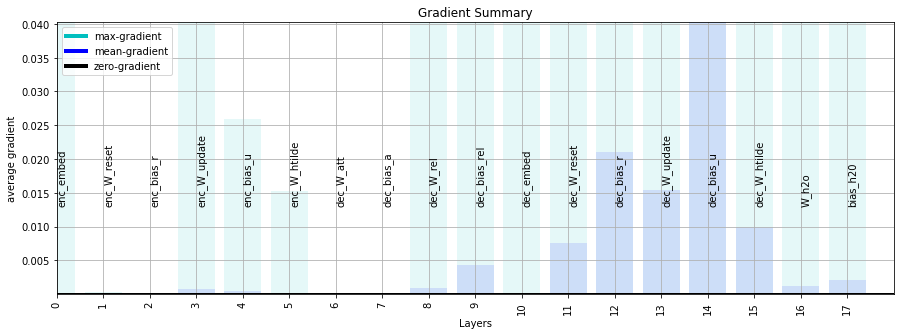

In [38]:
plt.figure(figsize=(15,5))
viz_tensors_bars(grads['encoder']+grads['decoder'], 
                names=names['encoder']+names['decoder'], y_ax_max="max_average", type="gradient")

layer 1 (enc_W_reset): mean -0.000000, std 9.105974e-06
layer 3 (enc_W_update): mean -0.000112, std 6.503414e-03
layer 5 (enc_W_htilde): mean +0.000011, std 6.782291e-04
layer 0 ( dec_W_att): mean -0.000000, std 7.696094e-09
layer 2 ( dec_W_rel): mean -0.000501, std 7.013008e-03
layer 5 (dec_W_reset): mean -0.000003, std 2.537765e-02
layer 7 (dec_W_update): mean +0.000216, std 4.752528e-02
layer 9 (dec_W_htilde): mean +0.000176, std 5.304128e-02
layer 10 (     W_h2o): mean +0.000000, std 2.159799e-02


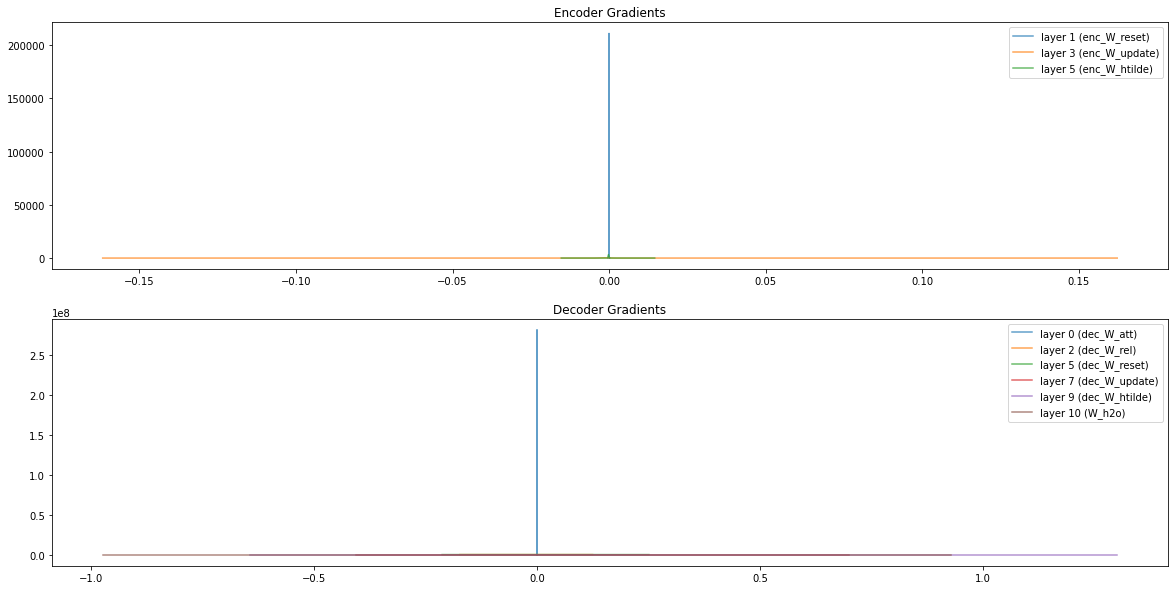

In [39]:
plt.figure(figsize=(20, 10))
plt.subplot(211)
viz_tensors_density(grads['encoder'], names['encoder'], exclude=['bias', 'embed'], print_info=True, title='Encoder Gradients')
plt.subplot(212)
viz_tensors_density(grads['decoder'], names['decoder'], exclude=['bias', 'embed'], print_info=True, title='Decoder Gradients')
plt.show()

## Inspect Weights

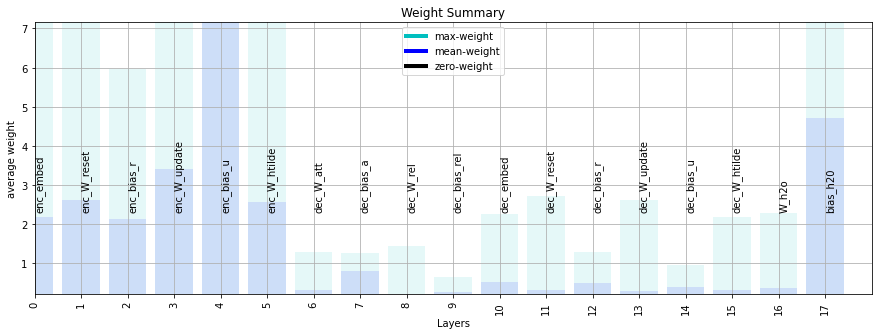

In [40]:
plt.figure(figsize=(15,5))
viz_tensors_bars(weights['encoder']+weights['decoder'], 
                names=names['encoder']+names['decoder'], y_ax_max="max_average", type="weight")

layer 1 (enc_W_reset): mean -0.025451, std 3.297881e+00
layer 3 (enc_W_update): mean -0.040604, std 4.385897e+00
layer 5 (enc_W_htilde): mean +0.076513, std 3.253187e+00
layer 0 ( dec_W_att): mean +0.168659, std 3.596152e-01
layer 2 ( dec_W_rel): mean -0.065227, std 2.823512e-01
layer 5 (dec_W_reset): mean +0.000567, std 4.469832e-01
layer 7 (dec_W_update): mean +0.014854, std 4.186584e-01
layer 9 (dec_W_htilde): mean +0.001174, std 4.331798e-01
layer 10 (     W_h2o): mean +0.028956, std 4.574246e-01


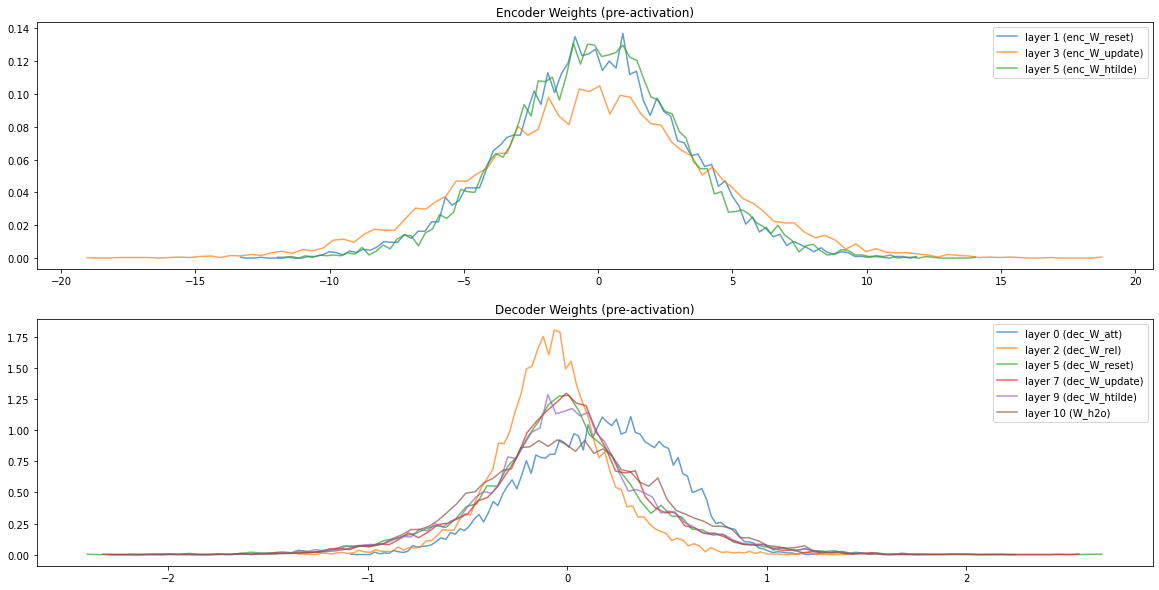

In [41]:
plt.figure(figsize=(20, 10))
plt.subplot(211)
viz_tensors_density(weights['encoder'], names['encoder'], exclude=['bias', 'embed'], print_info=True, title='Encoder Weights (pre-activation)')
plt.subplot(212)
viz_tensors_density(weights['decoder'], names['decoder'], exclude=['bias', 'embed'], print_info=True, title='Decoder Weights (pre-activation)')
plt.show()

## Plot Update / Weight Ratio over Training 

Text(0.5, 0.98, 'Update:Weight Ratio - std. dev. of update value / std. dev. of weight value')

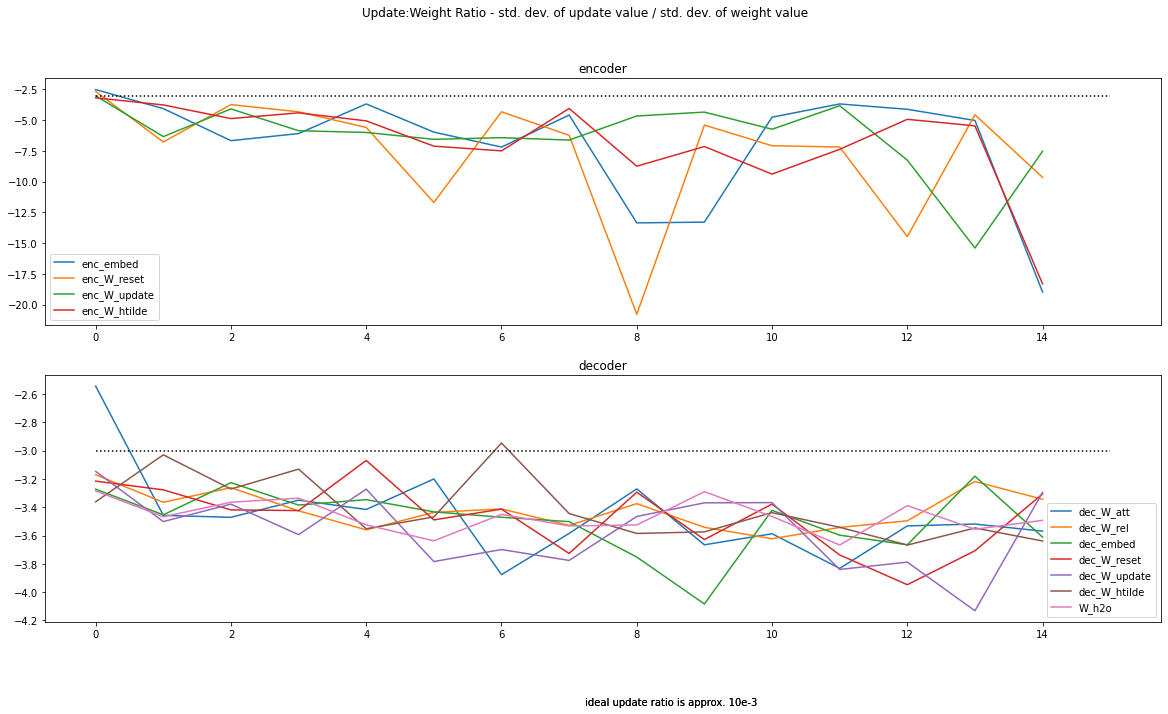

In [42]:
updateratio = model_dict['utils']['UpdateRatioTracker']

fig = plt.figure(figsize=(20,10))

plt.subplot(211)
plot_UpdateRatio(updateratio['encoder'], log10=True)
plt.title("encoder")

plt.subplot(212)
plot_UpdateRatio(updateratio['decoder'], log10=True)
plt.title("decoder")

fig.suptitle("Update:Weight Ratio - std. dev. of update value / std. dev. of weight value")


# Model inference

In [43]:
# Load saved model configuration
config = model_dict['config']

In [44]:
# Initalize a model with the same configuration and load in the trained weights
model = TranslGRU(config['english_vocab_size'], config['french_vocab_size'],
                  enc_embed_dim=config['enc_embed_dim'],
                  dec_embed_dim=config['dec_embed_dim'],
                  dec_type=config['dec_type'],
                  hidden_size=config['hidden_size'],
                  max_length=config['max_length'],
                  stoi_mapping=config['stoi'], 
                  start_chr=config['start_chr'], stop_chr=config['stop_chr']
                )

model.restore_weights(weights['encoder'], weights['decoder'], device=torch.device('cpu'))

In [47]:
# Translate!
model.translate("What a mess.")

'quel naze '